#**Importing libraries**

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [3]:
import tensorflow as tf
import os
from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

#**Split data**

Initial dataset consist of 2 classes *('FAKE', 'REAL')*, each class consist of **60 000** images.

The data was splited into three folders using below mentioned script.

**85%** - **TRAIN** data, **10%** - **VALIDATION** data, **5%** - **TEST** data

In [6]:
# pip install split-folders

In [7]:
# import splitfolders

# splitfolders.ratio("data", # The location of dataset
#                    output="ai_real_dataset", # The output location
#                    seed=42, # The number of seed
#                    ratio=(.85, .10, .05), # The ratio of splited dataset
#                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                    move=False # If you choose to move, turn this into True
#                    )

#**Load dataset**

## Load dataset from drive

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!unzip -uq "/content/drive/My Drive/ai_real_dataset.zip" -d "/content"

## Initiate Keras datasets from the uploaded files

In [10]:
train_dir = os.path.join('ai_real_dataset', 'train')
validation_dir = os.path.join('ai_real_dataset', 'val')
test_dir = os.path.join('ai_real_dataset', 'test')

In [11]:
BATCH_SIZE = 128
IMG_SIZE = (32, 32)
IMG_SHAPE = IMG_SIZE + (3,)

In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 102000 files belonging to 2 classes.


In [13]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 12000 files belonging to 2 classes.


In [14]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6000 files belonging to 2 classes.


## Plot images

['FAKE', 'REAL']


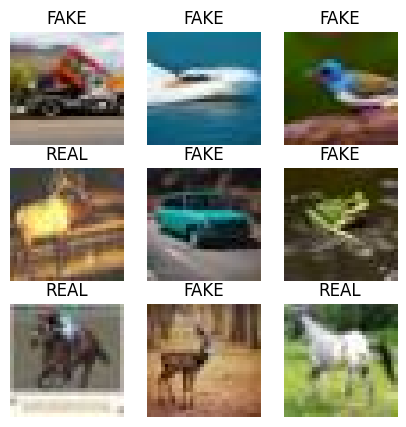

In [15]:
class_names = train_dataset.class_names

print(class_names)

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 797
Number of validation batches: 94
Number of test batches: 47


#### Optimize data loading performance

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# **Data aumentation**

## Augmentation layers

* **tf.keras.layers.RandomContrast(0.7):** randomly adjusts the contrast of images by a factor of 0.7, introducing variation in image appearance.

* **tf.keras.layers.RandomFlip('horizontal')**: randomly flips images horizontally, creating mirrored versions of the original images.

* **tf.keras.layers.RandomRotation(0.2)**: randomly rotates images by up to 0.2 radians, adding rotation-based diversity to the dataset.

* **tf.keras.layers.RandomZoom(0.3, 0.2)**: randomly zooms in or out on images, with zoom factors ranging from 0.3 to 0.2.

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(0.7),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.3, 0.2),
])

## Augmentation visualization

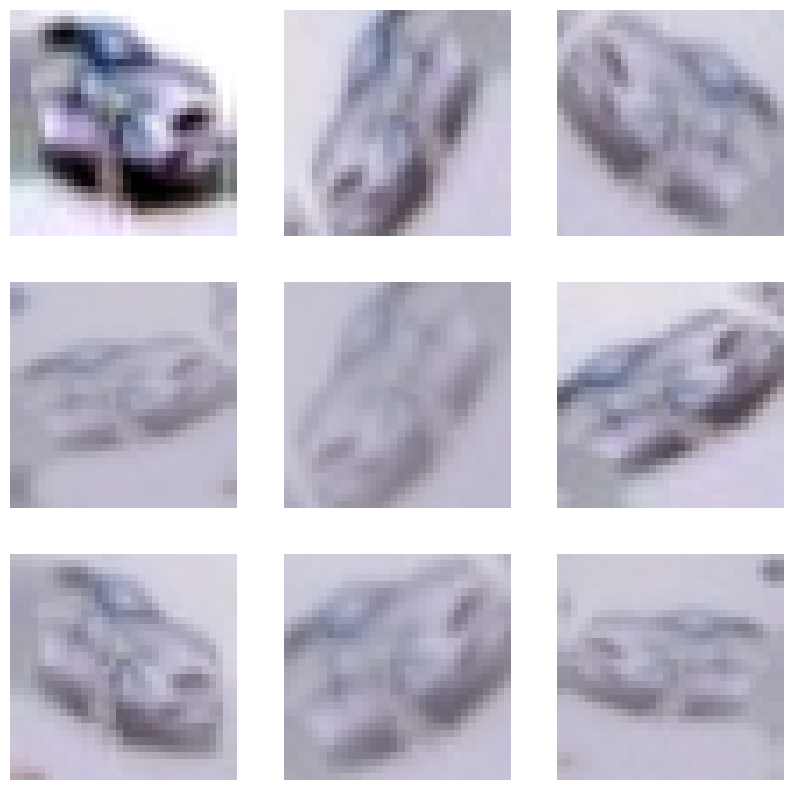

In [19]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## **CNN**

### Import libraries

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from keras.activations import relu
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import preprocess_input

### Built model

In [21]:
# Define the model
model1 = Sequential()

# Convolutional layers
model1.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMG_SHAPE))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model1.add(layers.Flatten())

# Dense layers
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))  # Optional dropout for regularization
model1.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (binary classification)


### Compile the model

In [22]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model summary

In [23]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 64)         

### Training model

In [24]:
history1 = model1.fit(train_dataset,
                    epochs=8,
                    validation_data=validation_dataset
                   )

Epoch 1/8
797/797 [==============================] - 110s 137ms/step - loss: 0.5230 - accuracy: 0.7753 - val_loss: 0.3590 - val_accuracy: 0.8426
Epoch 2/8
797/797 [==============================] - 99s 123ms/step - loss: 0.3377 - accuracy: 0.8612 - val_loss: 0.2753 - val_accuracy: 0.8850
Epoch 3/8
797/797 [==============================] - 92s 114ms/step - loss: 0.2982 - accuracy: 0.8798 - val_loss: 0.2619 - val_accuracy: 0.8963
Epoch 4/8
797/797 [==============================] - 86s 108ms/step - loss: 0.2741 - accuracy: 0.8899 - val_loss: 0.2405 - val_accuracy: 0.9052
Epoch 5/8
797/797 [==============================] - 87s 109ms/step - loss: 0.2585 - accuracy: 0.8978 - val_loss: 0.3089 - val_accuracy: 0.8738
Epoch 6/8
797/797 [==============================] - 86s 108ms/step - loss: 0.2450 - accuracy: 0.9034 - val_loss: 0.2352 - val_accuracy: 0.9004
Epoch 7/8
797/797 [==============================] - 92s 116ms/step - loss: 0.2273 - accuracy: 0.9110 - val_loss: 0.2206 - val_accuracy

## **EficientNet**

In [25]:
  base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape = IMG_SHAPE)

16705208/16705208 [==============================] - 0s 0us/step


In [26]:
#base_model.trainable = False

for layer in base_model.layers[:230]:
		layer.trainable = False

# for layer in base_model.layers[18:]:
# 		layer.trainable = True

In [ ]:
 base_model.summary()

In [31]:
inputs = layers.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)

x = preprocess_input(x)
x = base_model(x)
#x = AveragePooling2D(8,8)(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)

In [32]:
 model2 = Model(inputs, outputs)

In [33]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model2.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy() , metrics=['accuracy'])

In [34]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                             

In [35]:
history2 = model2.fit(train_dataset,
                    epochs=8,
                    validation_data=validation_dataset
                   )

Epoch 1/8
797/797 [==============================] - 312s 378ms/step - loss: 0.9305 - accuracy: 0.5758 - val_loss: 0.5441 - val_accuracy: 0.7337
Epoch 2/8
797/797 [==============================] - 296s 372ms/step - loss: 0.7775 - accuracy: 0.6334 - val_loss: 0.4975 - val_accuracy: 0.7654
Epoch 3/8
797/797 [==============================] - 293s 368ms/step - loss: 0.7184 - accuracy: 0.6573 - val_loss: 0.4818 - val_accuracy: 0.7727
Epoch 4/8
797/797 [==============================] - 298s 373ms/step - loss: 0.6743 - accuracy: 0.6715 - val_loss: 0.4664 - val_accuracy: 0.7847
Epoch 5/8
797/797 [==============================] - 296s 371ms/step - loss: 0.6416 - accuracy: 0.6842 - val_loss: 0.4579 - val_accuracy: 0.7887
Epoch 6/8
797/797 [==============================] - 295s 370ms/step - loss: 0.6164 - accuracy: 0.6983 - val_loss: 0.4509 - val_accuracy: 0.7930
Epoch 7/8
797/797 [==============================] - 299s 375ms/step - loss: 0.5943 - accuracy: 0.7067 - val_loss: 0.4501 - val_ac

## **Training process analysis**

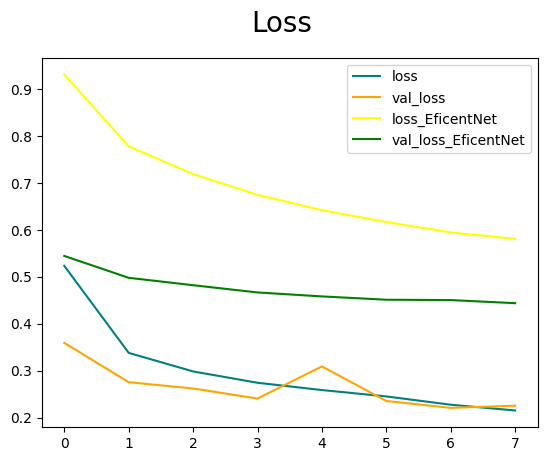

In [37]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(history1.history['loss'], color='teal', label='loss')
plt.plot(history1.history['val_loss'], color='orange', label='val_loss')
plt.plot(history2.history['loss'], color='yellow', label='loss_EficentNet')
plt.plot(history2.history['val_loss'], color='green', label='val_loss_EficentNet')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

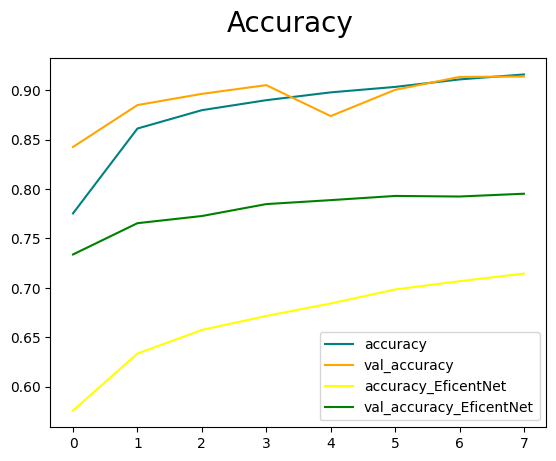

In [40]:
fig = plt.figure()
plt.plot(history1.history['accuracy'], color='teal', label='accuracy')
plt.plot(history1.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(history2.history['accuracy'], color='yellow', label='accuracy_EficentNet')
plt.plot(history2.history['val_accuracy'], color='green', label='val_accuracy_EficentNet')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

## **Testing**

In [65]:
predicted_classes1 = np.array([])
labels =  np.array([])

for x, y in test_dataset:
  predicted_classes1 = np.concatenate([predicted_classes1,
                       np.argmax(model1.predict(x), axis = -1)])
  labels = np.concatenate([labels, y.numpy()])

4/4 [==============================] - 0s 8ms/step


In [57]:
predicted_classes2 = np.array([])

for x, y in test_dataset:
  predicted_classes2 = np.concatenate([predicted_classes2,
                       np.argmax(model2.predict(x), axis = -1)])

4/4 [==============================] - 0s 76ms/step


In [63]:
print(labels)

[1. 1. 0. ... 1. 0. 0.]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

score = model1.evaluate(test_dataset, verbose=0)
cm = confusion_matrix(labels, predicted_classes1)

print(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {score[1]:.2%}'
plt.title(all_sample_title)
plt.savefig('foo.png')

print(classification_report(labels, predicted_classes1, target_names=class_names))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

score = model2.evaluate(test_dataset, verbose=0)
cm = confusion_matrix(labels, predicted_classes2)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {score[1]:.2%}'
plt.title(all_sample_title)
plt.savefig('foo.png')

print(classification_report(labels, predicted_classes2, target_names=class_names))

1/1 [==============================] - 0s 71ms/step


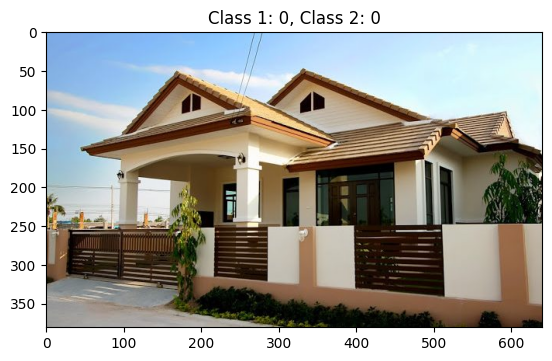

1/1 [==============================] - 0s 56ms/step


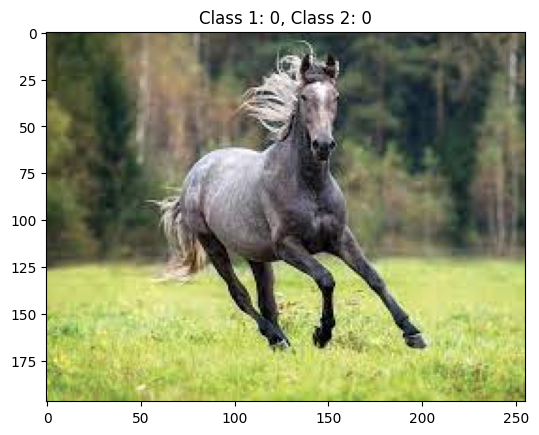

1/1 [==============================] - 0s 65ms/step


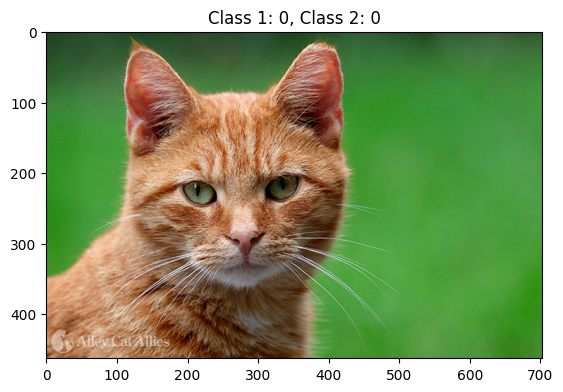

1/1 [==============================] - 0s 103ms/step


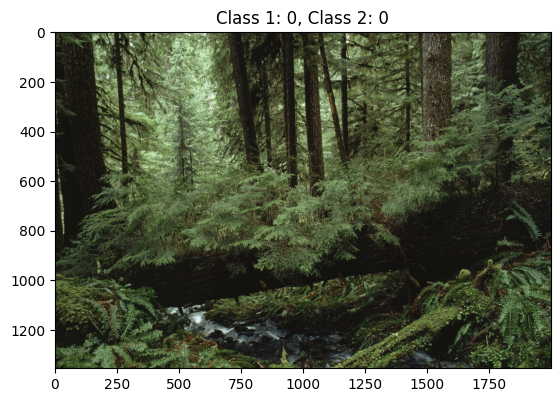

1/1 [==============================] - 0s 76ms/step


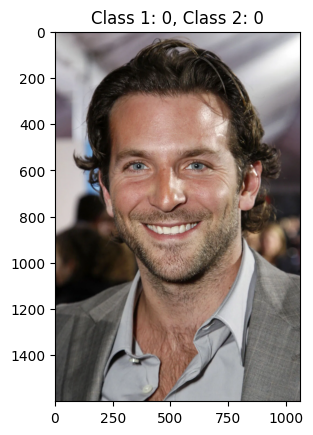

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model

# Ścieżka do folderu z obrazami wejściowymi
input_folder = '/content/drive/My Drive/testing/real'

# Funkcja do przetwarzania obrazów
def process_image(image_path):
    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalizacja

    return img_array

# Iteruj przez obrazy wejściowe
for filename in os.listdir(input_folder):
        input_image_path = os.path.join(input_folder, filename)

        # Przetwarzaj obraz za pomocą modelu1
        input_img_array = process_image(input_image_path)
        prediction1 = model1.predict(input_img_array)
        class1 = np.argmax(prediction1)

        # Przetwarzaj obraz za pomocą modelu2
        input_img_array = process_image(input_image_path)
        prediction2 = model2.predict(input_img_array)
        class2 = np.argmax(prediction2)

        # Twórz wykres z podpisem klas
        plt.figure()
        plt.imshow(image.load_img(input_image_path))
        plt.title(f'Class 1: {class1}, Class 2: {class2}')
        plt.show()
